In [1]:
%run TDA_helper_functions.ipynb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as la
import pandas as pd
import hdbscan


from ripser import ripser, lower_star_img
from persim import plot_diagrams
from scipy import sparse
from sklearn.decomposition import PCA

In [2]:
#import images and their respective labels

images = pd.read_csv('mnist_images_10k.csv.gz', compression='gzip', names=list(range(784))).to_numpy()
labels = np.genfromtxt('mnist_labels_10k.csv', dtype="int")

print(np.shape(images))
print('The images array has 10,000 rows. Each row has the 784 = 28x28 pixel values of an image.')

(10000, 784)
The images array has 10,000 rows. Each row has the 784 = 28x28 pixel values of an image.


8


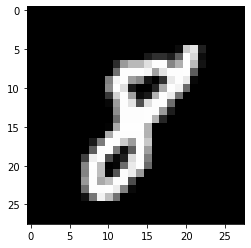

In [3]:
#An example of an image and its label

n = 17
img = np.rint(images[n].reshape(28,28))
plt.imshow(img, cmap="gray")
print(labels[n])

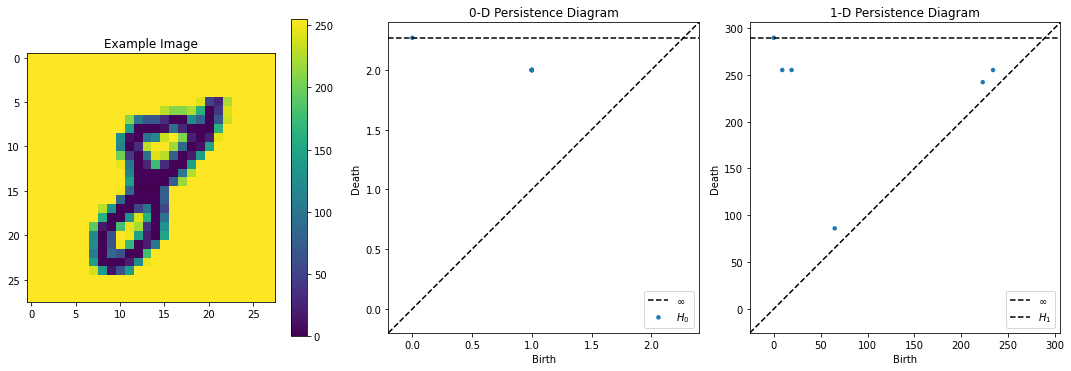

In [4]:
#Calculate persistence diagrams of the example image

neg_img = 255-img #want the number to be dark so it is captured in the lower level sets 

dgm = lower_star_img_new(neg_img) #calculates the H_0 and H_1 persistence diagrams of the sublevelset filtration
dgm0 = dgm[0]
dgm1 = dgm[1]
dgm1 = np.vstack((dgm1,[0.,np.inf]))

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(neg_img)
plt.colorbar()
plt.title("Example Image")

plt.subplot(132)
plot_diagrams(dgm0)
plt.title("0-D Persistence Diagram")

plt.subplot(133)
plot_diagrams(dgm1)
plt.title("1-D Persistence Diagram")
plt.legend(["$\infty$","$H_1$"])

plt.tight_layout()
plt.show()

LT0_list_ex = []
LT1_list_ex = []

LT0_list_ex.append(dgm[0][:,1] - dgm[0][:,0]) #list of life times of each point
LT1_list_ex.append(dgm[1][:,1] - dgm[1][:,0])

The points $(b,d)$ in the above persistence diagrams (PD's) describe the "births" and "deaths" of topological features in the lower level set filtration of the image. The lower level set filtration is the set $\{x : f(x) \leq t\}$, where $f : {0,1,2,\dots,27} \to \{0,1,2,\dots,255\}$ is the function that assigns a pixel value to each pixel location. In the PD's, the points $(b,d)$ with long lifetimes (i.e. those where $d-b$ is large) are the most significant. For example, in the 1-D PD for the digit 8 above, there are two points with lifetimes that are significantly longer than the others (about 250). Each of those points correspond to one of the two loops that form the 8. 

In [5]:
#makes lists of persistence diagrams and lifetimes (death time - birth time)

dgm_list = []

LT0_list = []
LT1_list = []

for n in range(1000):
    img = np.rint(images[n].reshape(28,28))
    
    neg_img = 255-img #want the number to be dark so it is captured in the lower level sets 

    dgm = lower_star_img_new(neg_img)
    dgm[0] = dgm[0][:-1]
    
    #list of life times of each point
    LT0_list.append(dgm[0][:,1] - dgm[0][:,0]) 
    LT1_list.append(dgm[1][:,1] - dgm[1][:,0])
    
    #store in a list
    dgm_list = dgm_list + [dgm]

In [11]:
#modifies lifetime list in order to classify numbers

LT0_mod_list = []
LT1_mod_list = []
p = .1
q = 50

for i in range(len(LT0_list)):
    if len(LT0_list[i]) != 0:
        temp_max = np.max(LT0_list[i])
        
        bln = (np.abs(LT0_list[i] - temp_max)/temp_max < p) & (LT0_list[i] > q)
        
        temp = LT0_list[i][bln]
        LT0_mod_list.append([temp,labels[i],i]) 
    #else:
         #LT0_0D.append([LT0_list[i],labels[i],i])
        
for i in range(len(LT1_list)):    
    if len(LT1_list[i]) != 0:
        temp_max = np.max(LT1_list[i])
        
        bln = (np.abs(LT1_list[i] - temp_max)/temp_max < p) & (LT1_list[i] > q)
        
        temp = LT1_list[i][bln]
        LT1_mod_list.append([temp,labels[i],i])
    #else:
         #LT1_0D.append([LT1_list[i],labels[i],i])
        
print(len(LT1_mod_list))

[[array([222.]), 6, 13], [array([213.]), 2, 16], [array([236., 246.]), 8, 17], [array([], dtype=float64), 6, 18]]


In [7]:
#sorts the digits that have 0,1,2, or some other number of significant points in their persistence diagrams

LT1_0D = []
LT1_1D = []
LT1_2D = []
LT1_else = []

for i in range(len(LT1_list)):
    if len(LT1_list[i]) == 0:
        LT1_0D.append([LT1_list[i],labels[i],i])

for i in range(len(LT1_mod_list)):
    if len(LT1_mod_list[i][0]) == 1:
        LT1_1D.append(LT1_mod_list[i])
    elif len(LT1_mod_list[i][0]) == 2:
        LT1_2D.append(LT1_mod_list[i])
    else:
        LT1_else.append(LT1_mod_list[i])

1000
(446, 407, 34, 113)


Text(0, 0.5, 'Number of digits')

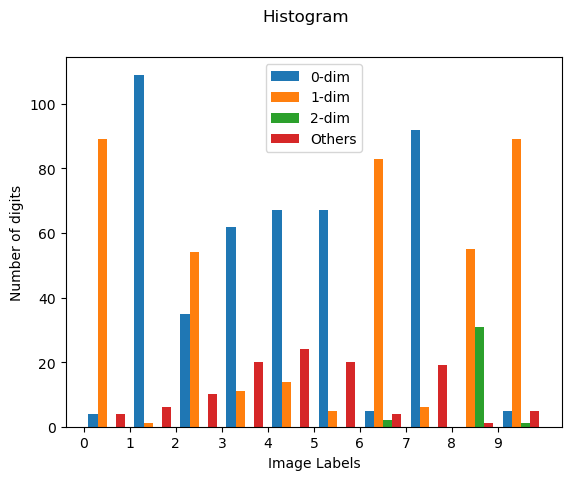

In [8]:
#Makes histograms of the results of the sorting

#Sanity checks
print(len(LT1_0D) + len(LT1_1D) + len(LT1_2D) + len(LT1_else))
print((len(LT1_0D), len(LT1_1D), len(LT1_2D), len(LT1_else)))

Ones = []
for item in LT1_0D:
    Ones.append(item[1])

Zeros = []
for item in LT1_1D:
    Zeros.append(item[1])

Eights = []
for item in LT1_2D:
    Eights.append(item[1])
    
Others = []
for item in LT1_else:
    Others.append(item[1])
    
fig, ax1 = plt.subplots(1, 1)
fig.suptitle('Histogram')

ax1.hist([Ones,Zeros,Eights,Others], bins = [0,1,2,3,4,5,6,7,8,9,10])
ax1.set_xticks(range(10))
ax1.legend(['0-dim','1-dim','2-dim','Others'])
plt.xlabel('Image Labels')
plt.ylabel('Number of digits')

Conclusion:

The above histogram shows that the TDA methods used correctly classifies much of the data set into its correct homology. 

Note that 0,1,5,6,7,9 are some especially sucessful cases considering that the large majority of those digits have the correct homology. The digits 2,4,8 have an honest mix of homologies. In the case of the 2 and 4 this is likely because the 2 is often drawn with or without a loop, and similarly for 4. The case of the 8 is interesting because majority of the 8's have a 1-dimensional homology group, while you expect them to be 2-dimensional. This is most likely due to one of the loops is an elongated and squished circle, which is effectively a line.

[0.51904968 0.22005282 0.0627583 ]
(3, 100)
[[ 1.08891336e-17  8.64426467e-18  1.55590719e-17]
 [-5.16291589e-02 -6.30527582e-02 -4.76705512e-02]
 [-4.58872730e-02  8.35146755e-02 -4.30660690e-02]
 [ 0.00000000e+00  4.44089210e-16 -2.49800181e-16]
 [-6.51871197e-02 -5.49589135e-03  3.04196436e-02]
 [-1.82103802e-01  1.35355925e-01  6.29743446e-02]
 [ 0.00000000e+00 -0.00000000e+00  5.55111512e-17]
 [ 0.00000000e+00  2.71050543e-20 -5.55111512e-17]
 [ 0.00000000e+00 -0.00000000e+00 -3.46944695e-18]
 [ 0.00000000e+00 -2.64697796e-23 -4.33680869e-19]
 [ 8.89908788e-02  6.78705922e-02  6.57875766e-02]
 [ 0.00000000e+00 -1.29246971e-26  3.38813179e-21]
 [ 0.00000000e+00 -2.01948392e-28  2.11758237e-22]
 [-3.49841999e-01  3.58621343e-01 -5.80325163e-02]
 [ 0.00000000e+00 -0.00000000e+00 -8.27180613e-25]
 [ 0.00000000e+00 -3.85185989e-34  0.00000000e+00]
 [-1.49963888e-01  3.44076730e-02 -1.40273988e-01]
 [-1.49791572e-01  8.11174857e-02 -2.44247349e-01]
 [-1.20099134e-02  2.07217498e-02 -2.5

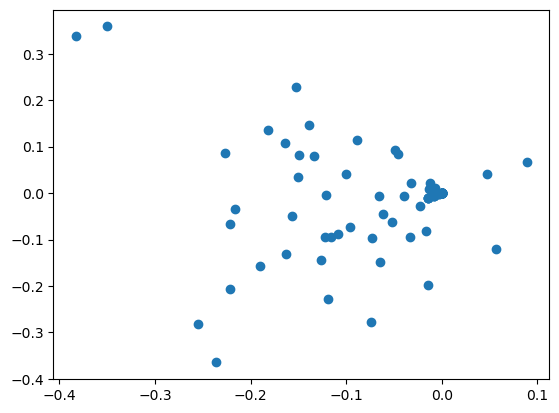

In [9]:
pca = PCA(n_components=3)
pca.fit(beta1_array.T)
print(pca.explained_variance_ratio_)
#print(pca.components_)
print(np.shape(pca.components_))
print(pca.components_.T)
plt.scatter(pca.components_.T[:,0],pca.components_.T[:,1])

In [10]:
#clustering
print(np.shape(beta1_array.T))
clusterer = hdbscan.HDBSCAN()
clusterer.fit(beta1_array)
labels = clusterer.labels_

(255, 100)


In [11]:
print(np.max(labels))
df = pd.DataFrame(beta1_array)
hdb_cluster = pd.DataFrame(labels)  
df = pd.concat([df, hdb_cluster], axis=1)
df.head(60)

1


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,-1
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [12]:
#TSNE

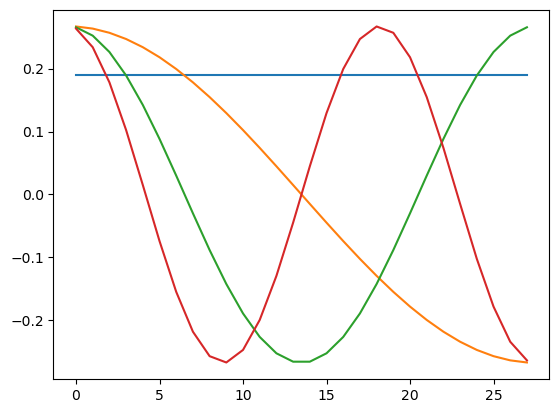

In [13]:
#discrete cosine transform
N = 28
D = np.zeros((N, N))

for i in range(N):
    D[i,:] = np.cos(np.pi*np.arange(N)*(i + .5)/N)
    
for k in range(N):
    D[:,k] = D[:,k]/la.norm(D[:,k])
    
#print(D)
plt.plot(D[:,:4])

1


Text(0.5, 1.0, 'DCT of image')

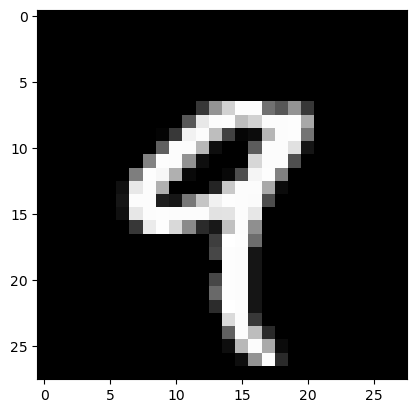

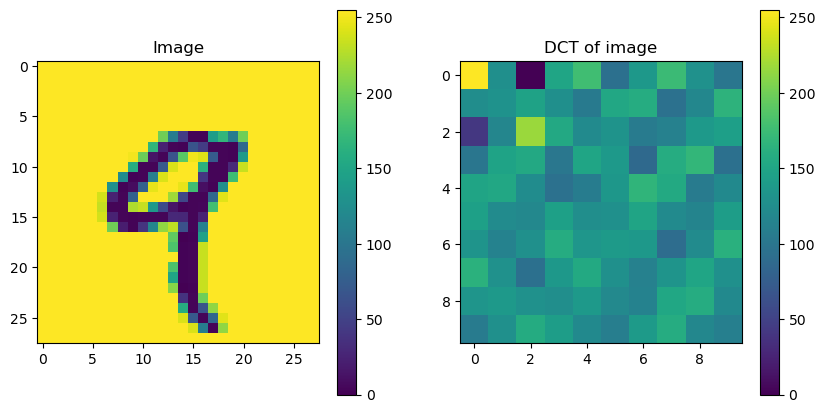

In [14]:
n_ex = 4
img_ex = images[n_ex].reshape(28,28)
plt.imshow(img_ex, cmap="gray")
print(labels[n_ex])

img_ex_neg = 255-img_ex
dgm_ex = lower_star_img_new(img_ex_neg)

img_ex_freq = D.T @ img_ex @ D
img_ex_freq = img_ex_freq - np.min(img_ex_freq)
img_ex_freq = (255/np.max(img_ex_freq))*img_ex_freq
#img_ex_freq = 255 - img_ex_freq

plt.figure(figsize = (10,5))

plt.subplot(121)
plt.imshow(img_ex_neg)
plt.colorbar()
plt.title("Image")

plt.subplot(122)
plt.imshow(img_ex_freq[:10,:10])
plt.colorbar()
plt.title("DCT of image")

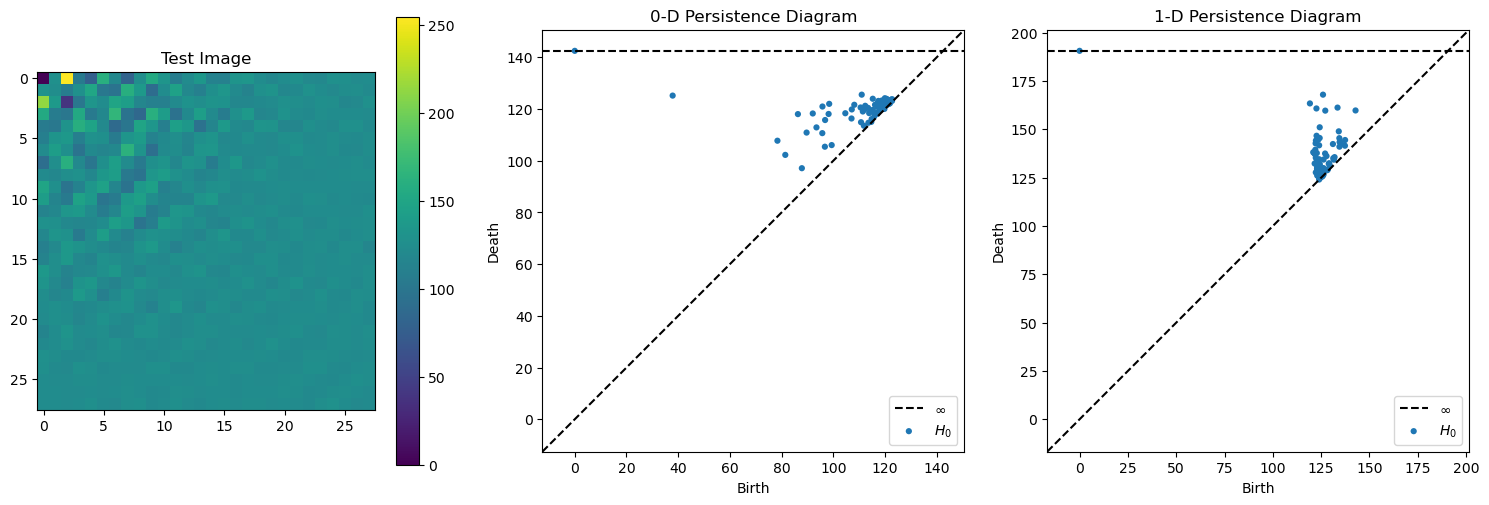

In [15]:
dgm = lower_star_img_new(255-img_ex_freq)
dgm0 = dgm[0]
dgm1 = dgm[1]
dgm1 = np.vstack([dgm1,[0.,np.inf]])

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(255-img_ex_freq)
plt.colorbar()
plt.title("Test Image")

plt.subplot(132)
plot_diagrams(dgm0)
plt.title("0-D Persistence Diagram")

plt.subplot(133)
plot_diagrams(dgm1)
plt.title("1-D Persistence Diagram")

plt.tight_layout()
plt.show()